## **Multiple Regression 📊**

#### **Initial Setup 🛠️**:
* 📚 **Import necessary libraries**  
* 🗂️ **Define data paths**  
* 📥 **Load data**  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression

from utils import *


In [2]:
pd.options.display.float_format = '{:.3f}'.format

In [3]:
df = pd.read_csv('../data/sales_mass_media/Advertising.csv').drop(columns='Unnamed: 0')
df.shape

(200, 4)

### **Check Available Data** 🛠️

1. **What Variables Are Available?**  
   - Identify the variables in the dataset:  
     - Which ones are **predictors**?  
     - Which is the **target variable**? 🎯

2. **What Are the Data Types of the Predictors?**  
   - Check whether the predictors are numeric, categorical, or of another type. 🔍

3. **Are There Any Missing Values?**  
   - If missing values exist:
     - How should they be **handled**?  
     - Options include imputation, removal, or other techniques. ⚙️


In [4]:
df.dtypes, df.isnull().sum(), df.describe()

(TV           float64
 Radio        float64
 Newspaper    float64
 Sales        float64
 dtype: object,
 TV           0
 Radio        0
 Newspaper    0
 Sales        0
 dtype: int64,
            TV   Radio  Newspaper   Sales
 count 200.000 200.000    200.000 200.000
 mean  147.042  23.264     30.554  14.023
 std    85.854  14.847     21.779   5.217
 min     0.700   0.000      0.300   1.600
 25%    74.375   9.975     12.750  10.375
 50%   149.750  22.900     25.750  12.900
 75%   218.825  36.525     45.100  17.400
 max   296.400  49.600    114.000  27.000)

### **Modeling** 📈

We are interested in predicting **sales** based on the amount spent on mass media. With three available mass media channels, a naive approach might be to use three separate **simple linear regressions**, one for each predictor.

#### Why This Approach Falls Short 🚨

This simple method introduces two key problems:

1. **Combining Media Budgets**:
   - Given three advertising media budgets, how do we calculate the **final value** of sales? 🤷‍♀️
   
2. **Ignoring Correlations**:
   - Each regression equation **ignores** the other two media when estimating the regression coefficients. This violates a key **OLS assumption**: regressors should not be correlated with each other. 📉

#### Conclusion 💡
To address these issues, we need a model that accounts for all predictors simultaneously while respecting the assumptions of OLS regression. This is where **multiple linear regression** comes in! ✅
We extend simple linear regression by giving each predictor a **separate slope coefficient**. The **multiple linear regression** model takes the form:

$$
Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \dots + \beta_pX_p + \epsilon
$$


In [5]:
# Extract predictors and target
X = df[['TV', 'Radio', 'Newspaper']]
Y = df['Sales']

In [6]:
for regressor in X:
    # Add a constant to the predictors (for intercept)
    regressor_with_constant = sm.add_constant(X[regressor])
    model = sm.OLS(Y, regressor_with_constant).fit()
    display(extract_regression_summary(model))

,coef,std err,t,P>|t|,0.025,0.975
const,7.033,0.458,15.360,0.000,6.130,7.935
TV,0.048,0.003,17.668,0.000,0.042,0.053


,coef,std err,t,P>|t|,0.025,0.975
const,9.312,0.563,16.542,0.000,8.202,10.422
Radio,0.202,0.020,9.921,0.000,0.162,0.243


,coef,std err,t,P>|t|,0.025,0.975
const,12.351,0.621,19.876,0.000,11.126,13.577
Newspaper,0.055,0.017,3.300,0.001,0.022,0.087


In [7]:
# Add a constant to the predictors (for intercept)
X_with_constant = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(Y, X_with_constant).fit()

display(extract_regression_summary(model))

,coef,std err,t,P>|t|,0.025,0.975
const,2.939,0.312,9.422,0.000,2.324,3.554
TV,0.046,0.001,32.809,0.000,0.043,0.049
Radio,0.189,0.009,21.893,0.000,0.172,0.206
Newspaper,-0.001,0.006,-0.177,0.860,-0.013,0.011


### ❓ Why Does Simple Linear Regression Suggest a Correlation Between Newspaper and Sales while multiple regression not?

The reason lies in the interpretation of coefficients:

1. **Simple Linear Regression**:
   - The coefficient represents the **average increase** in product sales associated with increasing newspaper spending **ignoring** the effects of TV and radio. 📄

2. **Multiple Linear Regression**:
   - The coefficient represents the **average increase** in product sales associated with increasing newspaper spending while **holding** TV and radio spending fixed. 📊

By incorporating all predictors, **multiple linear regression** provides a more nuanced understanding of the relationships, avoiding spurious conclusions. ✅

Looking at the **correlation matrix**, we discover a **spurious correlation**. 🧩

- The relationship between **Newspaper** and **Sales** is influenced by a third variable: **Radio**. 📻
- There is a **35% correlation** between **Radio** and **Newspaper**, which suggests:
  - When we spend a lot on newspaper advertising, we also tend to spend a lot on radio advertising. 💸
  - The correlation matrix reveals that **advertising in newspapers** has a weaker correlation with the target variable compared to **advertising in radio**. This suggests that **radio advertising** might have a stronger influence on the target variable and could be prioritized in the regression model for better predictive performance.

Thus, **Newspaper** is also capturing the effects of **Radio advertising**, leading to a misleading conclusion about its direct impact on **Sales**. 🚨


In [8]:
corr = round(df.corr(),3)*100
corr.style.background_gradient(cmap='Reds')

,TV,Radio,Newspaper,Sales
TV,100.000000,5.500000,5.700000,78.200000
Radio,5.500000,100.000000,35.400000,57.600000
Newspaper,5.700000,35.400000,100.000000,22.800000
Sales,78.200000,57.600000,22.800000,100.000000


### **Why Can't We Just Look at t-tests to check if there is a correlation between X-Y?** ❓
- T-tests are sensitive to the **number of predictors** used in regression.
- If we add 100 random variables, in 5% of the cases, we may find an association **by chance**. 🎲

There is a risk of **false discoveries** when examining t-values individually.

#### 🛠️ **Solution**
#### Perform a Hypothesis Test Using the F-Statistic 📈
- The **F-statistic** adjusts for the number of predictors in the model.
- However, while the F-test can tell us that **at least one variable** is correlated with our target (e.g., Sales), it doesn't identify which variable it is. 🤔

The correct approach is **variable selection**. ✅

#### **Main Idea**: Fit Different Models with Subsets of Predictors 🧩
- With \( p \) predictors, all possible combinations total are $ 2^p$. 🔢

We need an Efficient Approach: ⚡

1. **Forward Selection** ➡️: 
   - Start with **no predictors** in the model.  
   - Add predictors **one at a time**, choosing the one that improves the model (AIC score) the most at each step.  
   - Stop when adding more predictors does not significantly improve performance.
2. **Backward Selection** ⬅️:
    - Start with **all predictors** in the model.  
    - Remove predictors **one at a time**, eliminating the least significant predictor (p-value) at each step.  
    - Continue until all remaining predictors are statistically significant.  
3. **Mixed Selection** 🔄: 
    - A combination of forward and backward steps.  
    - Predictors can be **added** or **removed** at each step, depending on their contribution to the model.  
    - We continue to perform these forward and backward steps until all variables
in the model have a sufficiently low p-value, and all variables outside the model would have a large p-value if added to the model

In [9]:
# Generate 100 random variables with 200 observations each
num_variables = 100
num_observations = 200

random_data = pd.DataFrame(
    np.random.rand(num_observations, num_variables),
    columns=[f"Variable_{i+1}" for i in range(num_variables)]
)

In [10]:
test = pd.concat([df,random_data], axis=1)
display(test.head())

# Fit a regression using fake variables
test_with_constant = sm.add_constant(test.drop(columns=['Sales']))

# Fit the model using statsmodels
model_fake_x = sm.OLS(Y, test_with_constant).fit()

print('How many significant coefficients do we have?')
display(round(pd.Series(model_fake_x.pvalues < 0.05).value_counts(),4))

,TV,Radio,Newspaper,Sales,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,...,Variable_91,Variable_92,Variable_93,Variable_94,Variable_95,Variable_96,Variable_97,Variable_98,Variable_99,Variable_100
0,230.100,37.800,69.200,22.100,0.178,0.768,0.043,0.285,0.942,0.430,...,0.568,0.696,0.416,0.921,0.547,0.390,0.149,0.240,0.937,0.891
1,44.500,39.300,45.100,10.400,0.628,0.516,0.533,0.117,0.104,0.827,...,0.324,0.801,0.726,0.908,0.569,0.821,0.568,0.275,0.464,0.813
2,17.200,45.900,69.300,9.300,0.417,0.467,0.092,0.799,0.265,0.038,...,0.241,0.807,0.734,0.129,0.027,0.723,0.111,0.110,0.659,0.691
3,151.500,41.300,58.500,18.500,0.287,0.903,0.849,0.462,0.615,0.988,...,0.811,0.951,0.528,0.346,0.453,0.541,0.281,0.114,0.255,0.955
4,180.800,10.800,58.400,12.900,0.962,0.710,0.919,0.841,0.525,0.336,...,0.995,0.470,0.232,0.678,0.238,0.317,0.957,0.661,0.408,0.247


How many significant coefficients do we have?


False    96
True      8
Name: count, dtype: int64

In [11]:
f_value = model.fvalue
f_pvalue = model.f_pvalue

print(f'F-statistic: {f_value}')
print(f'p-value {f_pvalue}')

alpha = 0.05

if f_pvalue < alpha:
    print('Reject null hypotesis: at least one variable is related to Sales')

F-statistic: 570.2707036590941
p-value 1.5752272560924904e-96
Reject null hypotesis: at least one variable is related to Sales


#### **Perform feature selection**

In [12]:
forward_selection(data=X,response=Y)

Adding feature: TV with AIC: 1042.0913275363478
Adding feature: Radio with AIC: 778.3940987026804


['TV', 'Radio']

In [13]:
backward_elimination(data=X,response=Y)

Removing feature: Newspaper with p-value: 0.8599150500805818


['TV', 'Radio']

In [14]:
stepwise_selection(data=X,response=Y)

Adding feature: TV with AIC: 1042.0913275363478
Adding feature: Radio with AIC: 778.3940987026804


['TV', 'Radio']

## **Performance evaluation of the Best Model** 📈

Popular evaluation metrics for regression models include:

### 1. **RSE (Residual Standard Error)**:
   - **What it Measures**: RSE quantifies how well the model fits the data by measuring the average deviation of predictions from actual values.  
     - *Question it Answers*: How close are the predictions to the real values?
   - **Unit**: RSE is expressed in the same unit of measurement as the dependent variable \(Y\).  
   
   **Formula**:  
   $$
   RSE = \sqrt{\frac{RSS}{n - p - 1}}
   $$
   Where:
   - \(RSS\): Residual Sum of Squares.
   - \(n\): Number of observations.
   - \(p\): Number of predictors.
  
### 2. **R-squared**:
   - **What it Measures**: The proportion of variance in the dependent variable that is explained by the model.
   - **Range**: It varies between \(0\) and \(1\), where:
     - \(0\): The model explains none of the variance.
     - \(1\): The model explains all the variance.
   - **Limitations**:  
     - A high \(R^2\) does not guarantee an accurate model—it may still overfit the data or fail to capture important dynamics (e.g., interactions).

### 3. **Adjusted R-squared**
  - Also R-squared increase as number of predictors increase. A performance measure that takes into account number of variables is adjusted r squared.

### **Important Caveat: R-squared Doesn't Tell the Whole Story** 🔍
Observing the **3D plot**, we may notice **systematic underestimates and overestimates** in the model. This suggests the presence of an **interaction effect** between variables that is not accounted for in the model.

### **Key Takeaway**:
- While \(R^2\) and RSE are useful metrics, evaluating residual patterns (e.g., via plots) can reveal systematic issues like interaction effects that metrics alone might miss. Addressing these effects can improve model performance and reliability. 🚀


In [15]:
# Add a constant to the predictors (for intercept)
X_with_constant = sm.add_constant(X[['TV','Radio']])

# Fit the model using statsmodels
model = sm.OLS(Y, X_with_constant).fit()

print('Evaluation metrics')
print('---------------------')
print(f'R-squared: {model.rsquared}')
print(f'RMSE {np.sqrt(sum(model.resid*model.resid)*(1/(200-2-1)))}')

Evaluation metrics
---------------------
R-squared: 0.8971942610828957
RMSE 1.681360912508001


In [16]:
plot_3d_hyperplane(model, X_with_constant, Y, predictor1='TV', predictor2='Radio', title='3D Sales Prediction')


### **Our Model Performs Well, but What's the Accuracy of Our Estimates? 🎯**

1. **Confidence Interval 📐**:  
   - Measures the **uncertainty in the mean estimate** of the target variable. 
   - Interpretation: If we repeat the sampling process 100 times, **95% of the calculated confidence intervals** will contain the **true mean** (interactive viz: https://rpsychologist.com/d3/ci/)

2. **Prediction Interval 🔮**:  
   - Measures the **uncertainty in individual predictions**.  
   - Interpretation: If we repeat the sampling process and model fitting 100 times, **95% of the prediction intervals** will contain the **actual observed values** for new data points. 

So to summarize:

- A confidence interval captures the sampling uncertainty. More data means less sampling uncertainty, which in turn leads to a smaller interval.

- In addition to the sampling uncertainty, the prediction interval also represents the uncertainty in estimating the true value of a particular data point. Thus, it is wider than the confidence interval.


In [17]:
# Values of predictors for which to compute the confidence interval
new_data = pd.DataFrame({'const': [1], 'TV': [100_000], 'Radio': [20_000]})
# Mean refers to the confidence interval - obs referes to the prediction interval
model.get_prediction(new_data).summary_frame(0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,8338.287,206.461,7931.129,8745.445,7931.116,8745.458


### What happens if we introduce qualitative predictors? 🤔

Consider a new dataset: **Credit Scoring** 💳📊  
- **y = balance** (average credit card debt 💸)  
- **Predictors**:  
  - age 🧓👶  
  - cards 💳  
  - education (years) 🎓  
  - income ($) 💵  
  - limit 🔢  
  - rating ⭐  
  - **own (house ownership 🏠)**  

By introducing qualitative predictors, we can analyze how categorical factors, such as **house ownership** 🏠, influence **credit card debt** 💳💸.


In [18]:
df_credit = pd.read_csv('../data/credit/Credit.csv')
df_credit.shape

(400, 11)

In [19]:
display(df_credit.head(), df_credit['Own'].value_counts())

levels = df_credit['Own'].nunique()

print(f'* The variable has {levels} level')

# Create dummy variable

df_credit['Own_dummy'] = np.where(df_credit['Own'] == 'Yes', 1, 0)

display(df_credit['Own_dummy'].value_counts())

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


Own
Yes    207
No     193
Name: count, dtype: int64

* The variable has 2 level


Own_dummy
1    207
0    193
Name: count, dtype: int64

### **Fit Simple Model** 🧮

#### How do we interpret the coefficient of a regression with a coded variable? 🤔  
- **$B_0$**: Average credit card debt 💸 for non-owners 🏠🚫  
- **What's the average credit card debt for owners?**  
  $509.08 + 19.73 = 528.81$ 💳💵  

#### New Observation 🔍  
The new coded variable is **not significant** according to the p-value ❌📉.  
Perhaps this depends on the scheme used to code the variable (0-1) 🤷‍♀️.

#### What happens if we transform the variable into a dummy variable (-1, 1)? 🧐  
By changing the coding scheme, we might alter the interpretation ✨📈.  

- **$B_0$**: Average credit card debt 💸 ignoring house ownership effect 🏠🚫  
- **$B_1$**: Average difference between owners and non-owners



In [20]:
X = df_credit['Own_dummy']
Y = df_credit['Balance']

# Add a constant to the predictors (for intercept)
X_with_constant = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(Y, X_with_constant).fit()

display(extract_regression_summary(model))

# What happen if i change labels?
X_with_constant['Own_dummy'] = X_with_constant['Own_dummy'].replace(0,-1)

model = sm.OLS(Y, X_with_constant).fit()

display(extract_regression_summary(model))


,coef,std err,t,P>|t|,0.025,0.975
const,509.803,33.128,15.389,0.000,444.675,574.931
Own_dummy,19.733,46.051,0.429,0.669,-70.801,110.267


,coef,std err,t,P>|t|,0.025,0.975
const,519.670,23.026,22.569,0.000,474.403,564.937
Own_dummy,9.867,23.026,0.429,0.669,-35.400,55.134


### **What happens if we have more than 2 levels?** 🤔

The solution is to add **n-1 dummy variables** 🧮 to represent the remaining categories.  
The level with no dummy variable is known as the **baseline** 🏁.  

For example:  
- Categories: **South**, **West**, **East**  
- Dummy variables:  
  - **South = (1, 0)**  
  - **West = (0, 1)**  
  - **East = baseline (0, 0)** 🏁  

By using this approach, we ensure that all levels are accounted for without redundancy or multicollinearity 🔄📊.

All coefficient will be interpretated respect to the baseline category (East in this case)

In [21]:
display(df_credit['Region'].value_counts())import statsmodels.api as sm

levels = df_credit['Region'].nunique()

print(f'Variable has {levels} levels')

dummies  = pd.get_dummies(df_credit['Region'], drop_first=True).astype('int') # Remember to drop one level when using it in a regression model
df_credit = pd.concat([df_credit, dummies], axis=1)

df_credit.head(3)

Region
South    199
West     102
East      99
Name: count, dtype: int64

Variable has 3 levels


,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance,Own_dummy,South,West
0,14.891,3606,283,2,34,11,No,No,Yes,South,333,0,1,0
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903,1,0,1
2,104.593,7075,514,4,71,11,No,No,No,West,580,0,0,1


In [22]:
X = df_credit[['South','West']]
Y = df_credit['Balance']

# Add a constant to the predictors (for intercept)
X_with_constant = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(Y, X_with_constant).fit()import statsmodels.api as sm

display(extract_regression_summary(model))


,coef,std err,t,P>|t|,0.025,0.975
const,531.000,46.319,11.464,0.000,439.939,622.061
South,-12.503,56.681,-0.221,0.826,-123.935,98.930
West,-18.686,65.021,-0.287,0.774,-146.515,109.142


### **Are we missing something?** 🤔

The **linear regression model** makes restrictive assumptions 📏 that are often violated in the real world 🌍:

1. **Additivity** ➕:  
   The association between a predictor **$X_j$** and **$Y$** does not depend on the values of the other predictors 🔄.  
   _(This means no interactions between predictors!)_  

2. **Linearity** 📈:  
   The change in **$Y$** associated with one unit change in **$X_j$** is **constant**, regardless of the value of **$X_j$** 🔁.  
   _(For example, it implies that we could increase sales 📊 to infinity, which isn't realistic!)_


### **Treat Additivity Problem** 🛠️

The previously fitted model on **sales data** 📊 assumes that the **average increase in sales** associated with increasing **TV advertising** 📺 is **not influenced** by the amount spent on **radio advertising** 📻.

But what if **spending money on radio** 📻 increases the **effectiveness of TV advertising** 📺? 🤔  
How can we capture this relationship?  

#### Solution:  
We compute an **interaction term** 🔄:  
- Constructed by calculating the **product** between **TV** and **Radio**:  
  **TV × Radio** 📺✖️📻.

This allows the model to account for how the effect of **TV advertising** 📺 changes depending on **radio advertising** 📻 spend!

According results:
* an increase in TV advertising of $1,000 is associated with increased sales of 19+1.1×radio units
* increase in radio advertising of $1,000 will be associated with an increase in sales of 29 + 1.1 × TV units

**NB:** 📝  
Interaction term can be calculated as well to qualitative variables or to a combination of quantitative and qualitative variables

In [23]:
df['TVxRadio'] = df['TV']*df['Radio']

X = df.drop(columns=['Sales'])
Y = df['Sales']

# Add a constant to the predictors (for intercept)
X_with_constant = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(Y, X_with_constant).fit()

display(extract_regression_summary(model))

print(f'Adjusted-Rsquared: {model.rsquared_adj}') #Model is better with interaction effect

,coef,std err,t,P>|t|,0.025,0.975
const,6.728,0.253,26.561,0.000,6.229,7.228
TV,0.019,0.002,12.633,0.000,0.016,0.022
Radio,0.028,0.009,3.062,0.003,0.010,0.046
Newspaper,0.001,0.003,0.438,0.662,-0.005,0.008
TVxRadio,0.001,0.000,20.686,0.000,0.001,0.001


Adjusted-Rsquared: 0.9671621869307457


### **Treat Linearity Problem** 🛠️

Instead of fitting a **line** ➖, fit a **curve** ➰!  
This approach is called **polynomial regression** 📐📊.

By adding higher-degree terms (e.g., **$X^2$, $X^3$**, etc.), we can better capture **non-linear relationships** 🔄 between the predictors and the target variable.


In [24]:
df_car = pd.read_csv('../data/auto-mpg/auto-mpg.csv',
                     usecols=['mpg','horsepower'])
df_car.replace('?',np.nan, inplace = True)
df_car.dropna(axis = 0, how = 'any', inplace = True)
df_car['horsepower'] = df_car['horsepower'].astype('float64')
df_car.head()

,mpg,horsepower
0,18.000,130.000
1,15.000,165.000
2,18.000,150.000
3,16.000,150.000
4,17.000,140.000


In [25]:
df_car['horsepower_squared'] = df_car['horsepower']**2
df_car['horsepower_cubic'] = df_car['horsepower']**3

# Add a constant to the predictors (for intercept)
X_polynomial_sq = sm.add_constant(df_car[['horsepower','horsepower_squared']])

# Fit the model using statsmodels
polynomial_regression_sq = sm.OLS(df_car['mpg'], X_polynomial_sq).fit()

X_polynomial_cub = sm.add_constant(df_car[['horsepower','horsepower_squared','horsepower_cubic']])

polynomial_regression_cub = sm.OLS(df_car['mpg'], X_polynomial_cub).fit()

print(f'Adjusted rsquared polynomial regression (squared): {polynomial_regression_sq.rsquared_adj}')
print(f'Adjusted rsquared polynomial regression (cubic): {polynomial_regression_cub.rsquared_adj}')

Adjusted rsquared polynomial regression (squared): 0.6859526502069047
Adjusted rsquared polynomial regression (cubic): 0.6858029742583267


<Axes: xlabel='horsepower', ylabel='mpg'>

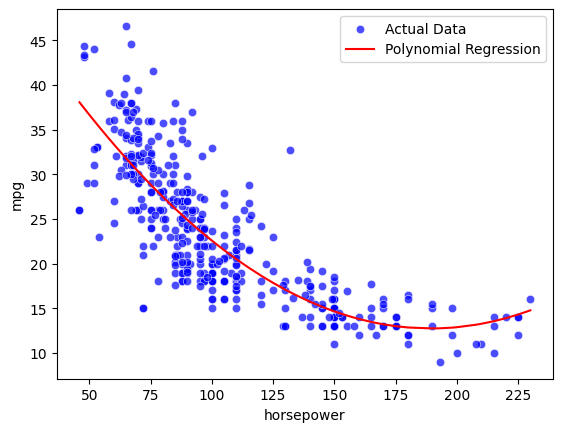

In [26]:
sns.scatterplot(x='horsepower', y='mpg', data=df_car, label='Actual Data', color='blue', alpha=.7)
sns.lineplot(x='horsepower', y=polynomial_regression_sq.fittedvalues, data=df_car, label='Polynomial Regression', color='red')

<Axes: xlabel='horsepower', ylabel='mpg'>

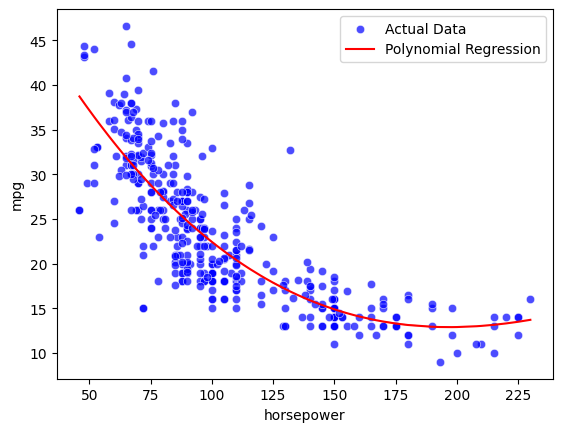

In [27]:
sns.scatterplot(x='horsepower', y='mpg', data=df_car, label='Actual Data', color='blue', alpha=.7)
sns.lineplot(x='horsepower', y=polynomial_regression_cub.fittedvalues, data=df_car, label='Polynomial Regression', color='red')

### **Verify if Assumptions of the Linear Regression Model Are Respected ✅**  

#### Common Problems to Watch Out For:  

- 📉 **Non-linearity of Response-Predictor Relationships**  
   - Check the **residual plot**: A key assumption in linear regression is that the relationship between predictors and the target is linear.  
   - For multiple regression, compare predicted and observed values. We aim for random points without patterns.  

- 🔄 **Correlation of Error Terms**  
   - If error terms are correlated, our confidence in the model may be **unwarranted**.  
   - Example: If data is accidentally duplicated, observations and error terms will be identical in pairs, misleading us to think the sample size is larger than it actually is.  

- 📊 **Non-constant Variance of Error Terms**  
   - **Heteroscedasticity** occurs when error variances increase with the response value.  
   - Solution: Transform the response $Y$ using a concave function, e.g., $log(Y)$, to stabilize the variance (check residual plots).  

- ⚠️ **Outliers**  
   - An **outlier** is a point where $y_i$ is far from the predicted value.  
   - Even if it does not affect the least squares fit much, it can distort evaluation metrics.  

- 📏 **Collinearity**  
   - When predictors are highly correlated, it becomes difficult to isolate their individual effects on the response.  

By addressing these issues, we ensure the reliability and robustness of our regression model! 🚀


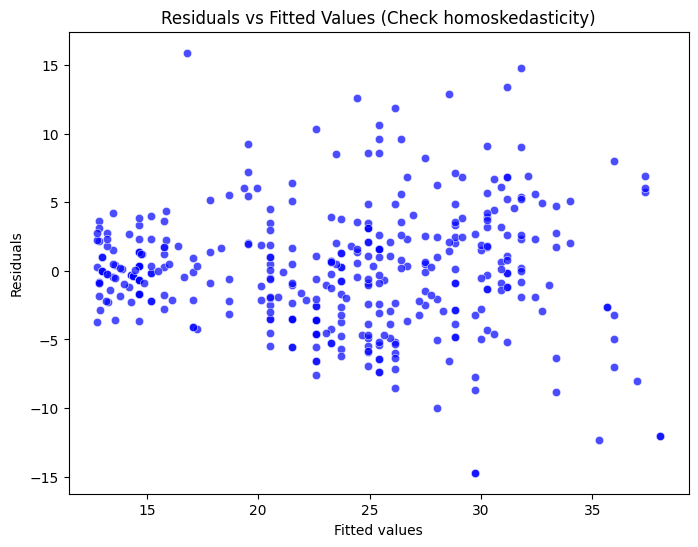

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=polynomial_regression_sq.fittedvalues, y=polynomial_regression_sq.resid,color='blue', alpha=.7)

# Set axis labels
plt.xlabel('Fitted values')  # Label for the x-axis
plt.ylabel('Residuals')  # Label for the y-axis
plt.title('Residuals vs Fitted Values (Check homoskedasticity)')  # Title for the plot
plt.show()

In [29]:
# Null Hypothesis (H₀): The residuals have constant variance (homoskedasticity).
# Alternative Hypothesis (H₁): The residuals have non-constant variance (heteroskedasticity).
het_breuschpagan(polynomial_regression_sq.resid, 
                X_polynomial_sq)[1] #pvalue

3.178682114507843e-08

In [30]:
#create instance of influence
influence = polynomial_regression_sq.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

#studentized residuals (computed by dividing each residual ei by its estimated standard studentized error.)
studentized_residuals = influence.resid_studentized_external

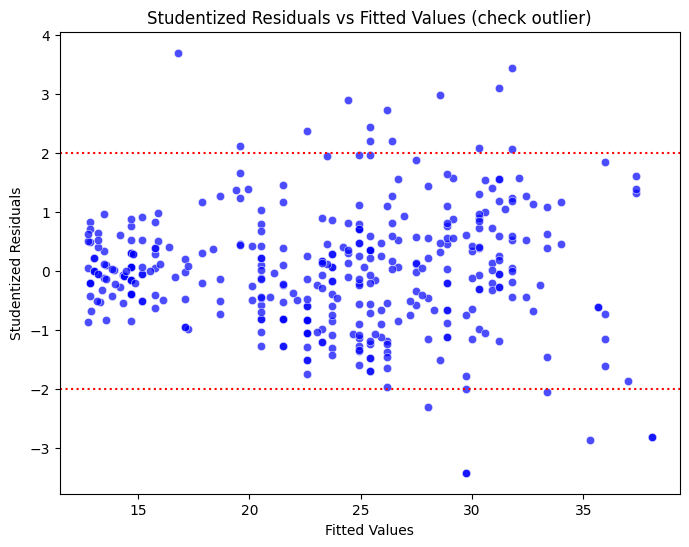

In [31]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=polynomial_regression_sq.fittedvalues, 
    y=studentized_residuals, 
    color='blue', 
    alpha=0.7
)

# Add horizontal lines at -2 and 2
plt.axhline(y=2, color='red', linestyle=':')
plt.axhline(y=-2, color='red', linestyle=':')

# Customize plot
plt.xlabel('Fitted Values')
plt.ylabel('Studentized Residuals')
plt.title('Studentized Residuals vs Fitted Values (check outlier)')
plt.show()

With one predictor levarage is calculated as: 
$$
h_i = \frac{1}{n} + \frac{(x_i - \bar{x})^2}{\sum_{i'=1}^{n} (x_{i'} - \bar{x})^2}
$$
There is an extension for multiple predictors, but the concept is that $h_i$ increases with the distance of $x_i$ from $\bar{x}$

Leverage varies between $1/n$ and 1.
Average leverage for all the observations is
always equal to $(p+1)/n$. So if a given observation has a leverage statistic
that greatly exceeds $(p+1)/n$, then we may suspect that the corresponding
point has high leverage.

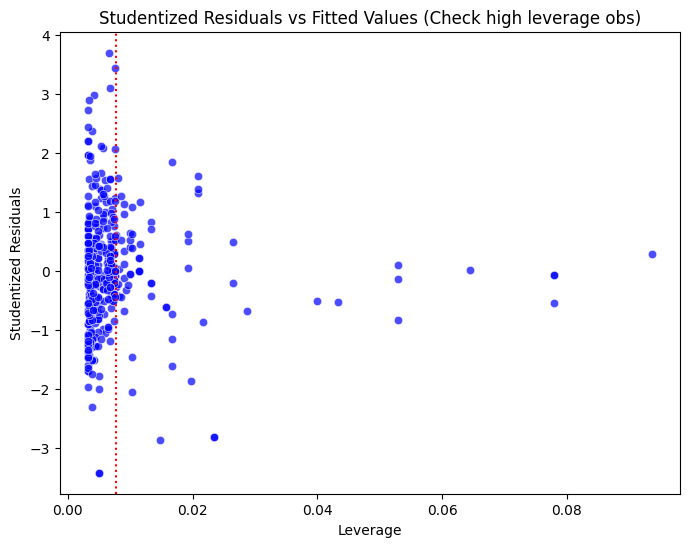

In [32]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=leverage, 
    y=studentized_residuals, 
    color='blue', 
    alpha=0.7
)

cutoff = leverage.mean()
# Add horizontal lines at -2 and 2
plt.axvline(x=cutoff, color='red', linestyle=':')

# Customize plot
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')
plt.title('Studentized Residuals vs Fitted Values (Check high leverage obs)')
plt.show()

In [33]:
# Calculate VIF for each variable
#VIF values:
#< 5: Low multicollinearity.
#5–10: Moderate multicollinearity.
#> 10: High multicollinearity; consider removing or combining variables.

# Assuming df_credit is your DataFrame containing the predictors
variables = ['Income', 'Rating', 'Cards']
X = df_credit[variables]  # Subset the DataFrame to include only the predictors

# Calculate VIF for each variable
vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

print(vif_data)

  Variable    VIF
0   Income  6.863
1   Rating 11.578
2    Cards  3.705


## **HANDS ON! 🛠️**
### **Ames Housing Dataset 🏠**

Metadata: https://jse.amstat.org/v19n3/decock/DataDocumentation.txt?

1. **Objective**:
   - Build a regression model to predict the **SalesPrice**.
   - Perform **feature selection**, train a regression model, and evaluate its performance.

7. **Model Evaluation**:
   - Evaluate the model on the testing set using:
     - **Adjusted R-squared** (goodness of fit)
     - **Mean Squared Error (MSE)** (error magnitude)
     - **Explainability** (the model with better explainability win)